In [1]:
# Homework 6 Template
# G. Besla & R. Li

In [2]:
# Add path to other HW folders / Modular Design
import sys
sys.path.append("../")

# import modules
from tqdm import tqdm
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from Homework2.ReadFile import Read
from Homework4.CenterOfMass import CenterOfMass

# Setup Matplotlib preferences
# adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [5]:
def OrbitCOM(galaxy, start, end, n=5):
    """function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
          
    returns: 
    """
    # compose the filename for output
    fileout = f"Orbit_{galaxy}.txt"
    
    #  set tolerance and VolDec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for VolDec
    if galaxy == 'M33':
        delta = 0.1
        VolDec = 4
    else:
        delta = 0.1
        VolDec = 5
    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, n, dtype=int)
    if snap_ids.size == 0:
        raise ValueError(f'Invalid snapshot range: {start} -> {end}')
    
    # initialize the array for orbital info: t, x, y, z, vx, vy, vz of COM
    orbits = np.zeros((snap_ids.size, 7))
    
    print(f"Iterating over {galaxy} snaps", flush=True)
    
    # a for loop; loop over snap files
    for i, snap_id in tqdm(enumerate(snap_ids), total=snap_ids.size, unit='snap'):
        # compose the data filename (be careful about the folder)
        filename = f'{galaxy}_VLowRes/{galaxy}_{snap_id:03d}.txt'
        
        # Initialize an instance of CenterOfMass class, using disk particles
        COMD = CenterOfMass(filename, 2)

        # Store the COM pos and vel. Remember that now COM_P required VolDec
        COMP = COMD.COM_P(delta, VolDec)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
    
        # store the time, pos, vel in ith element of the orbit array,  without units (.value) 
        # note that you can store 
        orbits[i] = COMD.time.value, *COMP.value, *COMV.value
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    np.savetxt(fileout, orbits, fmt = "%11.3f"*7, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [6]:
# Recover the orbits and generate the COM files for each galaxy
# read in 800 snapshots in intervals of n=5
# Note: This might take a little while - test your code with a smaller number of snapshots first! 

OrbitCOM('MW', 0, 800, n=5)
OrbitCOM('M31', 0, 800, n=5)
OrbitCOM('M33', 0, 800, n=5)

Iterating over MW snaps


100%|██████████| 160/160 [02:26<00:00,  1.09snap/s]

Iterating over M31 snaps



100%|██████████| 160/160 [14:31<00:00,  5.45s/snap]   

Iterating over M33 snaps



100%|██████████| 160/160 [00:33<00:00,  4.81snap/s]


In [7]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt
MW_data  = np.genfromtxt('Orbit_MW.txt')
M31_data = np.genfromtxt('Orbit_M31.txt')
M33_data = np.genfromtxt('Orbit_M33.txt')

time = MW_data[:, 0]/1000

In [8]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit

def VectorDiff(a, b):
    c = a - b
    return np.sqrt((c * c).sum(axis=1))

In [9]:
# Determine the magnitude of the relative position and velocities 

# of MW and M31
MWM31 = VectorDiff(MW_data[:, 1:4], M31_data[:, 1:4])
VMWM31 = VectorDiff(MW_data[:, 4:8], M31_data[:, 4:8])

# of M33 and M31
M33M31 = VectorDiff(M33_data[:, 1:4], M31_data[:, 1:4])
VM33M31 = VectorDiff(M33_data[:, 4:8], M31_data[:, 4:8])

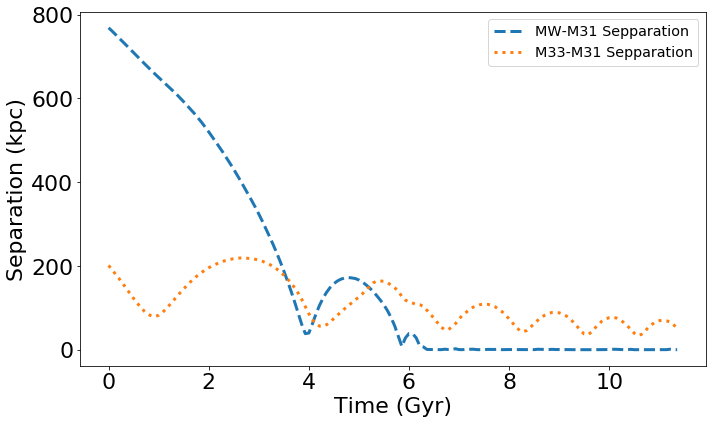

In [10]:
# Plot the Orbit of the galaxies 
#################################

# Setup canvas
fig, ax = plt.subplots(figsize=(10, 6))

# MW - M31 Velocity Sep
ax.plot(time, MWM31, linewidth=3, ls='--', label='MW-M31 Sepparation')

# M33-M31 Velocity Sep
ax.plot(time, M33M31, linewidth=3, ls=':', label='M33-M31 Sepparation')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)

# add a legend 
ax.legend(loc='upper right',fontsize='x-large')

plt.tight_layout()

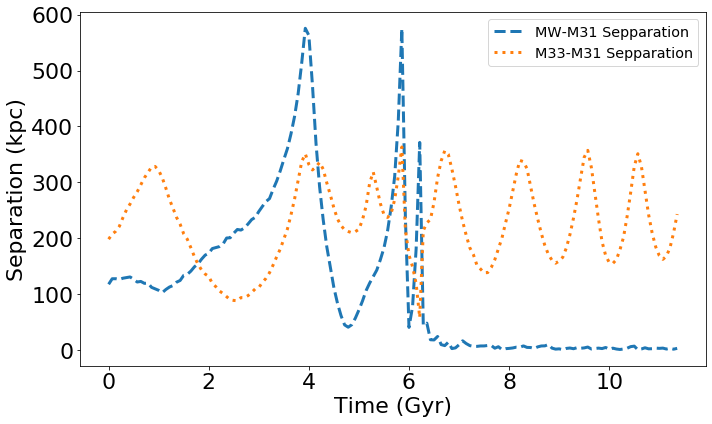

In [11]:
# Plot the orbital velocities of the galaxies 
#################################

# Setup canvas
fig, ax = plt.subplots(figsize=(10, 6))

### MW - M31 Velocity Sep
ax.plot(time, VMWM31, linewidth=3, ls='--', label='MW-M31 Sepparation')

## M33-M31 Velocity Sep
ax.plot(time, VM33M31, linewidth=3, ls=':', label='M33-M31 Sepparation')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)

# add a legend 
ax.legend(loc='upper right',fontsize='x-large')

plt.tight_layout()

## 4) Questions

1. They will pass by each other really close in some unstable orbit until they ultimately merge by ~6 Gyr
2. They resemble two-body orbits where they are the fastest at the orbit's periapsis, and the slowest at the orbit's apoapsis. Then velocity dies down as they merge.
3. The velocity completely dies out at around 7-7.5 Gyr. The M33's separation shows an artifact in the orbit at 6 Gyr; a bump, then begins a decaying orbit around the merger. 
